[I 2024-09-24 00:41:24,708] A new study created in memory with name: no-name-f2bc4d55-7e55-454e-bffd-2cff35a16030
[I 2024-09-24 00:41:55,231] Trial 0 finished with value: 750350181072896.0 and parameters: {'filters1': 121, 'kernel_size': 2, 'filters2': 238, 'dense_units': 56, 'epochs': 143}. Best is trial 0 with value: 750350181072896.0.
[I 2024-09-24 00:42:15,826] Trial 1 finished with value: 766674949111808.0 and parameters: {'filters1': 108, 'kernel_size': 3, 'filters2': 168, 'dense_units': 50, 'epochs': 99}. Best is trial 0 with value: 750350181072896.0.
[I 2024-09-24 00:42:35,373] Trial 2 finished with value: 756806993313792.0 and parameters: {'filters1': 65, 'kernel_size': 2, 'filters2': 71, 'dense_units': 114, 'epochs': 110}. Best is trial 0 with value: 750350181072896.0.
[I 2024-09-24 00:42:59,821] Trial 3 finished with value: 769675386421248.0 and parameters: {'filters1': 83, 'kernel_size': 5, 'filters2': 190, 'dense_units': 71, 'epochs': 103}. Best is trial 0 with value: 7503

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3147576983420928.0000 - val_loss: 3180676954193920.0000
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2946076982116352.0000 - val_loss: 3180671317049344.0000
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3471937745453056.0000 - val_loss: 3180647963164672.0000
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2941564582100992.0000 - val_loss: 3180577901510656.0000
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3378311753367552.0000 - val_loss: 3180411739963392.0000
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3168990348181504.0000 - val_loss: 3180073779724288.0000
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2959720751038464.0000 - val_loss: 3179444567015424.0000
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3027468759859200.0000 - val_loss: 3178374851723264.0000
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 324316362807

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Топ-10 признаков по важности:
                    Feature  Importance
47     underground_Аэропорт    0.965070
1               rooms_count    0.928565
29     district_Пресненский    0.910059
0              total_meters    0.829048
12     district_Даниловский    0.797900
37       district_Хамовники    0.784544
99  underground_Трикотажная    0.726977
34        district_Тверской    0.679848
39     district_Хорошевский    0.652160
82   underground_Павелецкая    0.640998


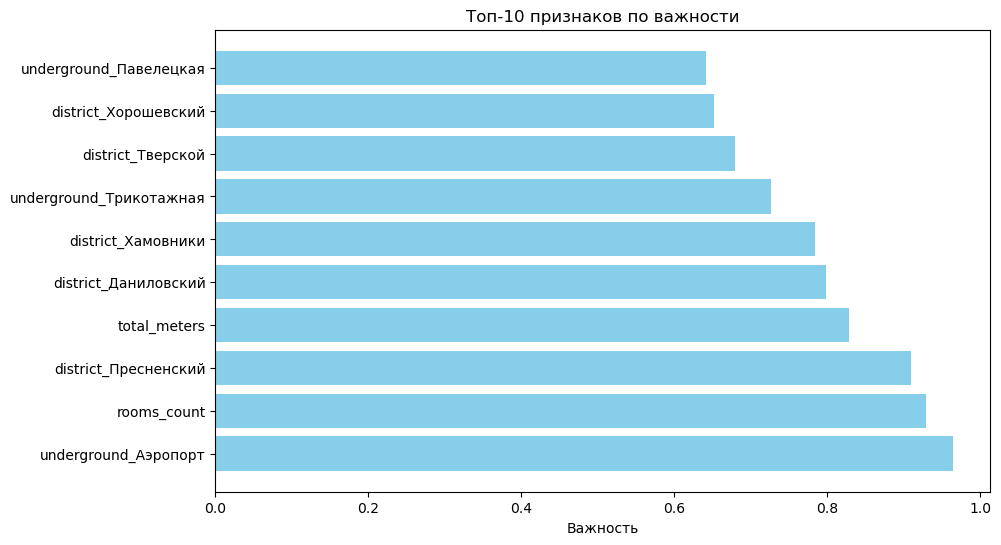

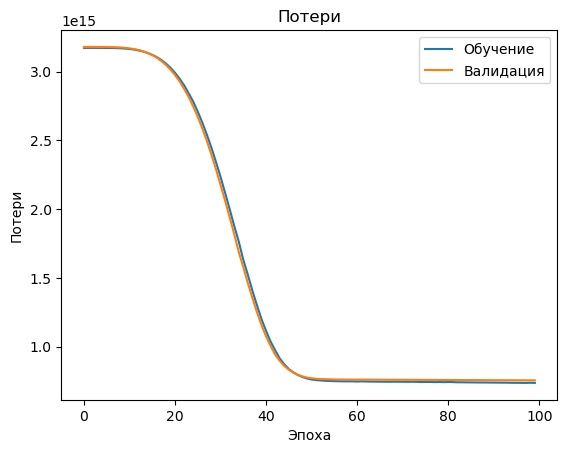

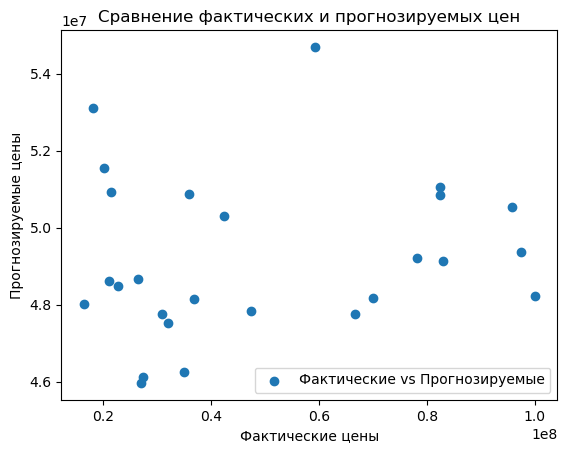

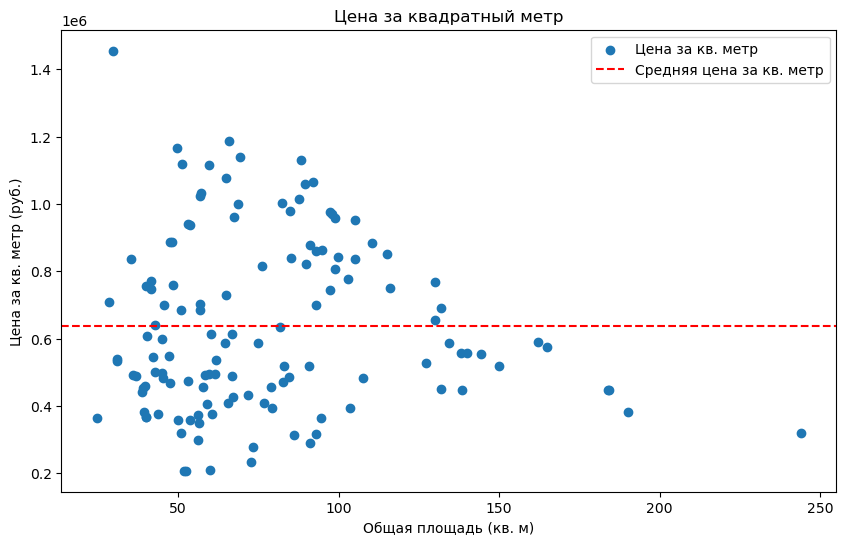

In [21]:
# CNN модель с Optuna

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import optuna

# Определяем путь к папке Sale
sale_folder = os.path.join(os.getcwd(), 'Sale')

# Находим все CSV файлы с 'sale' в названии в папке Sale
csv_files = glob.glob(os.path.join(sale_folder, '*sale*.csv'))

# Проверка наличия файлов
if not csv_files:
    raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")

# Сортировка файлов по времени создания и выбор последнего
latest_file = max(csv_files, key=os.path.getctime)

# Загрузка данных из последнего файла
data = pd.read_csv(latest_file, sep=',')

# Проверка наличия необходимых колонок
required_columns = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground', 'price']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"Отсутствует колонка: {col}")

# Выбор признаков и целевой переменной
features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground']
X = data[features]
y = data['price']

# Обработка категориальных признаков
categorical_features = ['district', 'underground']
numerical_features = ['total_meters', 'rooms_count', 'floor', 'floors_count']

# Создание трансформеров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров в колонный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных для использования в CNN
X_train = X_train.toarray().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.toarray().reshape((X_test.shape[0], X_test.shape[1], 1))

# Определение функции для создания модели
def create_model(trial):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(Conv1D(trial.suggest_int('filters1', 32, 128), kernel_size=trial.suggest_int('kernel_size', 2, 5), activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(trial.suggest_int('filters2', 64, 256), kernel_size=trial.suggest_int('kernel_size', 2, 5), activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(trial.suggest_int('dense_units', 32, 128), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Оптимизация гиперпараметров
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: create_model(trial).fit(X_train, y_train, epochs=trial.suggest_int('epochs', 50, 150), validation_data=(X_test, y_test), batch_size=10, verbose=0).history['val_loss'][-1], n_trials=10)

# Создание финальной модели с оптимизированными гиперпараметрами
final_model = create_model(study.best_trial)

# Обучение финальной модели
final_history = final_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=10)

# Оценка модели
loss = final_model.evaluate(X_test, y_test)
print(f'Потери на тестовых данных: {loss}')

# Прогнозирование цен на тестовых данных
predictions = final_model.predict(X_test)

# Пример вывода первых 10 прогнозов
for i in range(10):
    print(f'Фактическая цена: {y_test.iloc[i]}, Прогнозируемая цена: {predictions[i][0]}')

# Рассчет средней стоимости 1 кв. метра
data['price_per_sqm'] = data['price'] / data['total_meters']
average_price_per_sqm = data['price_per_sqm'].mean()
print(f'Средняя стоимость 1 кв. метра: {average_price_per_sqm}')

# Создание данных для прогнозирования на три года вперед
future_dates = [datetime.now() + timedelta(days=365 * i) for i in range(1, 4)]
future_features = pd.DataFrame({
    'total_meters': [100, 100, 100],
    'rooms_count': [2, 2, 2],
    'floor': [5, 5, 5],
    'floors_count': [10, 10, 10],
    'district': ['Центральный', 'Центральный', 'Центральный'],
    'underground': ['Китай-город', 'Китай-город', 'Китай-город'],
    'residential_complex': ['LUMIN', 'LUMIN', 'LUMIN']
})

# Преобразование данных для прогнозирования
future_features_transformed = preprocessor.transform(future_features)

# Преобразование данных для использования в CNN
future_features_transformed = future_features_transformed.toarray().reshape((future_features_transformed.shape[0], future_features_transformed.shape[1], 1))

# Прогнозирование цен на три года вперед
future_predictions = final_model.predict(future_features_transformed)

# Вывод прогнозов
for i, date in enumerate(future_dates):
    print(f'Дата: {date.strftime("%Y-%m-%d")}, Прогнозируемая цена за кв. метр: {future_predictions[i][0]}')

# Важность признаков
importance_model = Sequential()
importance_model.add(Dense(1, input_shape=(X_train.shape[1],)))
importance_model.compile(optimizer='adam', loss='mean_squared_error')
importance_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train, epochs=100, batch_size=10, verbose=0)

# Получаем важность признаков
feature_importances = np.abs(importance_model.layers[0].get_weights()[0]).flatten()
categorical_feature_names = list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names = numerical_features + categorical_feature_names

if len(feature_names) != len(feature_importances):
    raise ValueError("Количество признаков и их важность не совпадает.")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим топ-10 признаков
top_10_importance = importance_df.head(10)
print("Топ-10 признаков по важности:")
print(top_10_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Топ-10 признаков по важности')
plt.show()

# График потерь
plt.plot(final_history.history['loss'], label='Обучение')
plt.plot(final_history.history['val_loss'], label='Валидация')
plt.title('Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

# График прогнозов
plt.scatter(y_test, predictions, label='Фактические vs Прогнозируемые')
plt.xlabel('Фактические цены')
plt.ylabel('Прогнозируемые цены')
plt.legend()
plt.title('Сравнение фактических и прогнозируемых цен')
plt.show()

# График цены за кв. метр
plt.figure(figsize=(10, 6))
plt.scatter(data['total_meters'], data['price_per_sqm'], label='Цена за кв. метр')
plt.axhline(y=average_price_per_sqm, color='r', linestyle='--', label='Средняя цена за кв. метр')
plt.xlabel('Общая площадь (кв. м)')
plt.ylabel('Цена за кв. метр (руб.)')
plt.title('Цена за квадратный метр')
plt.legend()
plt.show()
